In [1]:
import tensorflow as tf

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

import keras.backend as K
#import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
df = pd.read_csv('data/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')
df = df[df.label_name == 'skirt_length']

display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
3,Images/skirt_length_labels/950638e668ca8414c47...,skirt_length,nnnynn
8,Images/skirt_length_labels/e27d2fe6a95132f3948...,skirt_length,nnnnny
14,Images/skirt_length_labels/ee53d9dacc7981314f4...,skirt_length,nnmynn
15,Images/skirt_length_labels/de76328babb30ea3ab9...,skirt_length,nnnynn
36,Images/skirt_length_labels/86323784d0344a262bd...,skirt_length,nnynnn


Counter({'skirt_length': 9223})

In [5]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'skirt_length': 6}

In [6]:
n = len(df)
print(n)

9223


In [7]:
fnames = df['filename'].values
width = 399

y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
df = df.reset_index(drop=True)

In [8]:
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1
    #y[label_names.index(label_name)][i, label.find('m')] = 0.5

In [9]:
print(fnames[0:10])
print(n)
print(len(y[0]))
print(len(y))
print(label_count.keys())
print(len(y[0][0]))

['Images/skirt_length_labels/950638e668ca8414c47f78a5c187aba5.jpg'
 'Images/skirt_length_labels/e27d2fe6a95132f39483deaadc1368d4.jpg'
 'Images/skirt_length_labels/ee53d9dacc7981314f404d6647465a49.jpg'
 'Images/skirt_length_labels/de76328babb30ea3ab9420b501d6e75e.jpg'
 'Images/skirt_length_labels/86323784d0344a262bd6a25515c8e8f1.jpg'
 'Images/skirt_length_labels/cd3e49af0176ddbab6c4586b4d5099ca.jpg'
 'Images/skirt_length_labels/c2c7fbd84e6c7a6714b63d8f7b35a208.jpg'
 'Images/skirt_length_labels/8ef9e97519fc254cc41a46315fbe38b5.jpg'
 'Images/skirt_length_labels/37cba08383feee2910c948c337436ed4.jpg'
 'Images/skirt_length_labels/ff2b2ac572ba12a23a84129804666406.jpg']
9223
9223
1
dict_keys(['skirt_length'])
6


In [10]:
def f(index):
    if os.path.isfile('data/'+fnames[index]):
        return index, cv2.resize(cv2.imread('data/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 9223/9223 [00:16<00:00, 556.74it/s]


In [11]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [12]:
from dataset import *
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

In [13]:
base_model = ResNet50(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

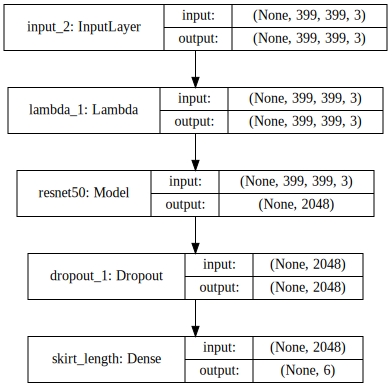

In [14]:
input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_skirt_length.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model2 = multi_gpu_model(model, n_gpus)

In [16]:
model2.compile(optimizer = Adam(0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=8, validation_data=(X_valid, y_valid))

Epoch 1/8
231/231 [==============================] - 321s 1s/step - loss: 1.0297 - acc: 0.6212 - val_loss: 0.6410 - val_acc: 0.7875
Epoch 2/8
231/231 [==============================] - 282s 1s/step - loss: 0.5766 - acc: 0.7955 - val_loss: 0.4997 - val_acc: 0.8287
Epoch 3/8
231/231 [==============================] - 275s 1s/step - loss: 0.4483 - acc: 0.8426 - val_loss: 0.4761 - val_acc: 0.8385
Epoch 4/8
231/231 [==============================] - 277s 1s/step - loss: 0.3699 - acc: 0.8713 - val_loss: 0.5203 - val_acc: 0.8293
Epoch 5/8
231/231 [==============================] - 284s 1s/step - loss: 0.3060 - acc: 0.8899 - val_loss: 0.4756 - val_acc: 0.8363
Epoch 6/8
231/231 [==============================] - 278s 1s/step - loss: 0.2608 - acc: 0.9084 - val_loss: 0.7165 - val_acc: 0.8092
Epoch 7/8
231/231 [==============================] - 281s 1s/step - loss: 0.2400 - acc: 0.9156 - val_loss: 0.5173 - val_acc: 0.8412
Epoch 8/8
231/231 [==============================] - 282s 1s/step - loss: 0.

In [17]:
model2.compile(optimizer = Adam(0.000025),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
231/231 [==============================] - 316s 1s/step - loss: 0.1218 - acc: 0.9600 - val_loss: 0.5337 - val_acc: 0.8515
Epoch 2/3
231/231 [==============================] - 275s 1s/step - loss: 0.1098 - acc: 0.9631 - val_loss: 0.5171 - val_acc: 0.8488
Epoch 3/3
231/231 [==============================] - 271s 1s/step - loss: 0.0769 - acc: 0.9760 - val_loss: 0.5213 - val_acc: 0.8526


In [18]:
model2.compile(optimizer = Adam(0.00000625),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
231/231 [==============================] - 304s 1s/step - loss: 0.0624 - acc: 0.9797 - val_loss: 0.4940 - val_acc: 0.8678
Epoch 2/3
231/231 [==============================] - 268s 1s/step - loss: 0.0614 - acc: 0.9807 - val_loss: 0.4932 - val_acc: 0.8678
Epoch 3/3
231/231 [==============================] - 270s 1s/step - loss: 0.0527 - acc: 0.9844 - val_loss: 0.5171 - val_acc: 0.8672


In [19]:
model2.compile(optimizer = Adam(0.00000425),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
231/231 [==============================] - 314s 1s/step - loss: 0.0462 - acc: 0.9862 - val_loss: 0.5060 - val_acc: 0.8650


In [20]:
model2.compile(optimizer = Adam(0.000001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
231/231 [==============================] - 318s 1s/step - loss: 0.0503 - acc: 0.9839 - val_loss: 0.5048 - val_acc: 0.8656


In [21]:
model_name = 'resnet_skirt_length'

model.save('model_%s.h5' % model_name)